# Liberie e Dataset

###Librerie

In [ ]:
from __future__ import print_function
!pip install wordcloud
import pandas as pd
import json


import numpy as np
import random
import os
import string
import collections
import re
import datetime


from google.colab import drive
from google.colab import files
drive.mount('/content/drive')


import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.stem.lancaster import LancasterStemmer
lancaster= LancasterStemmer()
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.__version__

from itertools import chain
import pandas as pd
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

from sklearn.datasets import load_iris
from sklearn.decomposition import TruncatedSVD 
import numpy as np
!pip install  gensim==4.0.0

from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (precision_recall_curve, auc, confusion_matrix,
                             f1_score, fbeta_score, precision_score,
                             recall_score, classification_report)
import itertools
!pip install -q pyLDAvis==2.1.2
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.sklearn
import pyLDAvis.gensim
from gensim.models.coherencemodel import CoherenceModel
from pprint import pprint
import imblearn

# Original Dataset

In [9]:
# ORIGINAL DATASET - BELOW SAMPLED DATASET
with open("/content/drive/MyDrive/TMS/goodreads_reviews_spoiler.json") as json_file:      
    data = json_file.readlines() 
    data = list(map(json.loads, data))
dt = pd.DataFrame(data)
dt.head()

,user_id,timestamp,review_sentences,rating,has_spoiler,book_id,review_id
0,8842281e1d1347389f2ab93d60773d4d,2017-08-30,"[[0, This is a special book.], [0, It started ...",5,True,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb
1,8842281e1d1347389f2ab93d60773d4d,2017-03-22,"[[0, Recommended by Don Katz.], [0, Avail for ...",3,False,16981,a5d2c3628987712d0e05c4f90798eb67
2,8842281e1d1347389f2ab93d60773d4d,2017-03-20,"[[0, A fun, fast paced science fiction thrille...",3,True,28684704,2ede853b14dc4583f96cf5d120af636f
3,8842281e1d1347389f2ab93d60773d4d,2016-11-09,"[[0, Recommended reading to understand what is...",0,False,27161156,ced5675e55cd9d38a524743f5c40996e
4,8842281e1d1347389f2ab93d60773d4d,2016-04-25,"[[0, I really enjoyed this book, and there is ...",4,True,25884323,332732725863131279a8e345b63ac33e


In [10]:
dt['timestamp'] = pd.to_datetime(dt['timestamp'])
dt.sort_values(by='timestamp', inplace=True)

In [11]:
# random sample of a subset
df_reviews = dt.sample(n=7000, random_state=1235)
df_reviews.to_csv("/content/drive/MyDrive/TMS/df_reviews_basic.csv")


# Random Sample Dataset


In [12]:
# SAMPLED DATASET
df_reviews = pd.read_csv("/content/drive/MyDrive/TMS/df_reviews_basic.csv")

#Case-Folding

In [13]:
df_reviews.review_sentences = df_reviews.review_sentences.str.lower()

# Removal

## Remove URL

In [14]:
df_reviews.review_sentences = df_reviews.review_sentences.str.replace(r'https?://\S+|www\.\S+', '', regex=True)
df_reviews.review_sentences = df_reviews.review_sentences.str.replace(r'http?://\S+|www\.\S+', '', regex=True)
df_reviews.review_sentences = df_reviews.review_sentences.str.replace(r'http://\S+|www\.\S+', '', regex=True)
df_reviews.review_sentences = df_reviews.review_sentences.str.replace(r'https://\S+|www\.\S+', '', regex=True)

## remove_emoji

In [15]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [16]:
df_reviews.review_sentences = df_reviews.review_sentences.apply(lambda x: remove_emoji(x))

## Remove Numbers

In [17]:
df_reviews.review_sentences = df_reviews.review_sentences.str.replace(r'\d+', '', regex=True)

## remove_stopwords

In [18]:
! pip install stop-words
from stop_words import get_stop_words
from nltk.corpus import stopwords

stop_words = list(get_stop_words('en'))         #About 900 stopwords
nltk_words = list(stopwords.words('english')) #About 150 stopwords
stop_words.extend(nltk_words)

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=f6387846da43a2f7e33c2dc31b59efd225eae89ceab6c145c9b5565bd3d60b8d
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [19]:
df_reviews.review_sentences = df_reviews.review_sentences.apply(lambda text: remove_stopwords(text))

## remove_punctuation

In [20]:
df_reviews.review_sentences = df_reviews.review_sentences.apply(lambda text: text.translate(str.maketrans('', '', string.punctuation)))

## remove_whitespaces

In [21]:
def remove_whitespaces(text):
    return " ".join(text.split())

In [22]:
df_reviews.review_sentences = df_reviews.review_sentences.apply(lambda text: remove_whitespaces(text))

In [23]:
df_reviews.head()

,Unnamed: 0,user_id,timestamp,review_sentences,rating,has_spoiler,book_id,review_id
0,727864,6d37c9d85f0493f6181236abab273071,2013-12-18,this book simply outstanding i adore it excuse...,5,False,13489925,ba3c4d5f2df6770b8e2c160746159763
1,45124,28bb1befa414f50bb067d75de0ea2e5d,2015-01-12,love gideon stars eva gideons story continues ...,4,False,17876893,c4f0cec0c4b4b164d27ed9b15e6b89c7
2,1128253,f61b23c294bf04dab05df6bc3b0f77ff,2012-12-20,hoover awesome book i loved slammed wanted fin...,5,False,15717943,06b33af6ecb84e7f99625da889a5cb4f
3,657634,cc589432bb9400a77e5609802647f8cc,2013-08-02,well finished it at first sure feel it story c...,3,False,477338,d8be5263382efc069a3be8947a17a461
4,1355444,f28393b10fae7195c7fd50bd9f871e6e,2015-12-31,shakespeare stands head shoulders literature h...,5,False,1420,3aef2827369d0f91b197291ee9f77aaa


In [24]:
len(df_reviews)

7000

### remove NAN values

In [25]:
 df_reviews[df_reviews["review_sentences"] == ""] 

,Unnamed: 0,user_id,timestamp,review_sentences,rating,has_spoiler,book_id,review_id


In [26]:
nan_value=float("NaN")
df_reviews.replace('', nan_value, inplace=True)
df_reviews[df_reviews["review_sentences"].isna() == True]
df_reviews.dropna(inplace=True, axis=0)
len(df_reviews)

7000

# Tokenization and lemmatization



In [27]:
# tokenization
df_reviews['tokenized'] = df_reviews.review_sentences.apply(lambda x: word_tokenize(x))

In [28]:
# CLEANING TOKENIZATION FROM MEANINGLESS WORDS
for a in range(2):
  for row in df_reviews['tokenized']:
      i = 0
      row_1 = row
      while i <= len(row):
        for word in row:
          if (len(word) < 2) or (len(word) >= 18): # removes words with more than 18 characters or less than 1
            row_1.remove(word) 
          elif re.search(r'((\w)\2{3,})', word): # removes letters repeated more than 2 times
            row_1.remove(word)
          elif re.search(r'((\w\w)\2{2,})', word): # removes groups of 2 letters repeated more than 2 times
            row_1.remove(word)
          elif re.search(r'((\w\w\w)\2{2,})', word): # removes groups of 3 letters repeated more than 2 times
            row_1.remove(word)
          i+=1
      row = row_1

In [30]:
# review sentence with all preprocessing steps in a single format and lemmatization
import nltk
nltk.download('omw-1.4')

df_reviews['lemmatized'] = df_reviews['tokenized'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x])

i = -1
df_reviews.insert(6,'review_sentences_preprocessed', '')
for row in df_reviews.lemmatized:
  i += 1
  stringa = ''
  stringa = stringa + (" ".join(row))
  df_reviews['review_sentences_preprocessed'][i] = stringa

df_reviews['review_sentences_preprocessed'] = df_reviews['review_sentences_preprocessed'].apply(lambda text: remove_stopwords(text))


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [31]:

i = -1
for row in df_reviews.review_sentences_preprocessed:
  i += 1
  lista = []
  lista = df_reviews['review_sentences_preprocessed'][i].split()
  df_reviews['lemmatized'][i] = lista

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# POS

In [32]:
# POS tagging
df_reviews['POS'] = df_reviews['tokenized'].apply(lambda x: [ nltk.pos_tag(x)])
df_reviews.drop(columns=['user_id', 'Unnamed: 0', 'book_id', 'review_id'], inplace = True)
df_reviews.to_json("/content/drive/MyDrive/TMS/df_reviews_pos.json")

In [33]:
df_reviews = pd.read_json("/content/drive/MyDrive/TMS/df_reviews_pos.json")
df_reviews

,timestamp,review_sentences,rating,has_spoiler,review_sentences_preprocessed,tokenized,lemmatized,POS
0,2013-12-18,this book simply outstanding i adore it excuse...,5,False,book simply outstanding adore excuse need go r...,"[this, book, simply, outstanding, adore, it, e...","[book, simply, outstanding, adore, excuse, nee...","[[[this, DT], [book, NN], [simply, RB], [outst..."
1,2015-01-12,love gideon stars eva gideons story continues ...,4,False,love gideon star eva gideons story continues w...,"[love, gideon, stars, eva, gideons, story, con...","[love, gideon, star, eva, gideons, story, cont...","[[[love, NN], [gideon, NN], [stars, NNS], [eva..."
2,2012-12-20,hoover awesome book i loved slammed wanted fin...,5,False,hoover awesome book loved slammed wanted find ...,"[hoover, awesome, book, loved, slammed, wanted...","[hoover, awesome, book, loved, slammed, wanted...","[[[hoover, RB], [awesome, JJ], [book, NN], [lo..."
3,2013-08-02,well finished it at first sure feel it story c...,3,False,well finished first sure feel story character ...,"[well, finished, it, at, first, sure, feel, it...","[well, finished, first, sure, feel, story, cha...","[[[well, RB], [finished, VBN], [it, PRP], [at,..."
4,2015-12-31,shakespeare stands head shoulders literature h...,5,False,shakespeare stand head shoulder literature ham...,"[shakespeare, stands, head, shoulders, literat...","[shakespeare, stand, head, shoulder, literatur...","[[[shakespeare, NN], [stands, VBZ], [head, JJ]..."
...,...,...,...,...,...,...,...,...
6995,2011-02-05,some spoilers follow interesting opening page ...,2,False,spoiler follow interesting opening page though...,"[some, spoilers, follow, interesting, opening,...","[spoiler, follow, interesting, opening, page, ...","[[[some, DT], [spoilers, NNS], [follow, VBP], ..."
6996,2015-06-25,loved it i worried like shifter books surprise...,5,False,loved worried like shifter book surprised enjo...,"[loved, it, worried, like, shifter, books, sur...","[loved, worried, like, shifter, book, surprise...","[[[loved, VBD], [it, PRP], [worried, VBD], [li..."
6997,2015-10-23,theres nothing romantic falling love gorgeous ...,5,False,nothing romantic falling love gorgeous guy rom...,"[theres, nothing, romantic, falling, love, gor...","[nothing, romantic, falling, love, gorgeous, g...","[[[theres, NNS], [nothing, NN], [romantic, JJ]..."
6998,2012-11-03,i little disappointed loving second book trilo...,4,False,little disappointed loving second book trilogy...,"[little, disappointed, loving, second, book, t...","[little, disappointed, loving, second, book, t...","[[[little, RB], [disappointed, JJ], [loving, V..."


# TEXT REPRESENTATION


## Bag of Word

In [34]:
# list of tokens for each document
texts = df_reviews['lemmatized'] 
doc_id = 0
texts[doc_id][:5]

['book', 'simply', 'outstanding', 'adore', 'excuse']

In [35]:
dictionary = Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.5)

In [36]:
corpus_1 = [dictionary.doc2bow(text) for text in texts]
[(dictionary[k], v) for k, v in corpus_1[0][:10]]

[('adore', 1),
 ('excuse', 1),
 ('go', 1),
 ('immediately', 1),
 ('need', 1),
 ('outstanding', 1),
 ('reread', 1),
 ('simply', 1)]

## TF-IDF

In [37]:
tfidf_vect = TfidfVectorizer(min_df = 3, ngram_range=(2, 2), use_idf = True)
df_reviews_tfidf = tfidf_vect.fit_transform(df_reviews.review_sentences_preprocessed).toarray()
df_reviews_tfidf.shape

(7000, 27823)

## Word Embedding: SVD with PPMI

In [38]:
# Corpus of all words together

corpus = []
def sum_string (row):
  for word in row:
    corpus.append(word)
  return corpus
df_reviews.lemmatized.apply(sum_string) 

0       [book, simply, outstanding, adore, excuse, nee...
1       [book, simply, outstanding, adore, excuse, nee...
2       [book, simply, outstanding, adore, excuse, nee...
3       [book, simply, outstanding, adore, excuse, nee...
4       [book, simply, outstanding, adore, excuse, nee...
                              ...                        
6995    [book, simply, outstanding, adore, excuse, nee...
6996    [book, simply, outstanding, adore, excuse, nee...
6997    [book, simply, outstanding, adore, excuse, nee...
6998    [book, simply, outstanding, adore, excuse, nee...
6999    [book, simply, outstanding, adore, excuse, nee...
Name: lemmatized, Length: 7000, dtype: object

In [39]:
# Bigram creation
finder = BigramCollocationFinder.from_words(corpus, window_size = 3)
finder.apply_freq_filter(3) # filter out rare co-occurrences (frequency less than 3)
finder.ngram_fd.items()

dict_items([(('book', 'simply'), 18), (('book', 'outstanding'), 4), (('excuse', 'go'), 5), (('need', 'go'), 17), (('need', 'reread'), 6), (('go', 'reread'), 15), (('reread', 'love'), 5), (('immediately', 'love'), 5), (('love', 'star'), 14), (('gideon', 'eva'), 6), (('story', 'continues'), 14), (('story', 'waiting'), 6), (('continues', 'book'), 7), (('waiting', 'book'), 18), (('book', 'excited'), 15), (('book', 'love'), 212), (('excited', 'two'), 3), (('love', 'two'), 35), (('love', 'character'), 129), (('two', 'character'), 92), (('two', 'go'), 5), (('character', 'go'), 27), (('character', 'really'), 145), (('go', 'really'), 21), (('really', 'review'), 7), (('review', 'saw'), 4), (('review', 'book'), 172), (('saw', 'book'), 19), (('book', 'positive'), 4), (('book', 'well'), 141), (('positive', 'really'), 3), (('well', 'really'), 46), (('well', 'enjoyed'), 9), (('really', 'enjoyed'), 307), (('really', 'book'), 272), (('enjoyed', 'book'), 205), (('enjoyed', 'installment'), 4), (('book', 

In [41]:
# PMI calculation
bigram_measures = nltk.collocations.BigramAssocMeasures()
pmi = bigram_measures.pmi # calculates pmi
pmis = finder.score_ngrams(pmi) # scores pmi in descending order
pmis[-5:]

[(('character', 'page'), -2.7383904342964804),
 (('book', 'mother'), -2.75323827464965),
 (('series', 'life'), -2.78708673969653),
 (('really', 'many'), -2.8831541311043978),
 (('first', 'way'), -3.05889101615616)]

In [42]:
# PPMI calculation
ppmis = []
for (w1, w2), pmi in pmis:
  ppmi = (w1, w2), max(0, pmi)
  ppmis.append(ppmi)
ppmis[-5:]

[(('character', 'page'), 0),
 (('book', 'mother'), 0),
 (('series', 'life'), 0),
 (('really', 'many'), 0),
 (('first', 'way'), 0)]

In [ ]:
# unique terms in bigrams
vocab = list({term for tuple_ in finder.ngram_fd for term in tuple_}) 

In [ ]:
vocab_to_index = {word: i for i, word in enumerate(vocab)} 

In [ ]:
# empty matrix
matrix = np.zeros((len(vocab), len(vocab))) 

In [ ]:
# populate the matrix
for (w1, w2), ppmi in ppmis:
  matrix[vocab_to_index[w1], vocab_to_index[w2]] = ppmi 

matrix.shape

(5346, 5346)

In [ ]:
# SVD with 300 features
svd = TruncatedSVD(n_components= 300) 
X = svd.fit_transform(matrix)
X.shape

(5346, 300)

In [ ]:
la = np.linalg
U, s, vh = la.svd(X, full_matrices = False) # decompose X in U, s and Vh
# now we use only U for simplicity
U.shape

(5346, 300)

In [ ]:
cos = cosine_similarity(X) #calculate cosine similarity
U_weighted = cos.dot(U) # Apply a ramp window based on distance between the words in the document.

# Text classification (TF-IDF)


### Spoiler/ non Spoiler

In [ ]:
# proportion of spoilers
df_reviews.groupby("has_spoiler").size()/(df_reviews.shape[0]) 

has_spoiler
False    0.940286
True     0.059714
dtype: float64

In [ ]:
X = df_reviews_tfidf
y = df_reviews['has_spoiler']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)

In [ ]:
print(f'dataset size: {len(y_train)}, no spoiler: {y_train[y_train == False].count()}, spoiler {y_train[y_train == True].count()}')

dataset size: 4690, no spoiler: 4404, spoiler 286


In [ ]:
# oversampling majority class
oversample = imblearn.over_sampling.SMOTE(sampling_strategy='minority') 
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [ ]:
print(f'dataset size: {len(y_train)}, no spoiler: {y_train[y_train == False].count()}, spoiler {y_train[y_train == True].count()}')

dataset size: 8808, no spoiler: 4404, spoiler 4404


In [ ]:
def score_model(clf, X_train, X_test, y_train, y_test):
    train_score = clf.score(X_train, y_train) # Train Accuracy
    test_score = clf.score(X_test, y_test)    # Test Accuracy

    predictions = clf.predict(X_test)

    prec = precision_score(y_test, predictions)
    rec = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions) # F1
    f2 = fbeta_score(y_test, predictions, beta=2) # F2
    cm = confusion_matrix(y_test, predictions)
    scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                      "Test Recall", "Test F1", "Test F2"]

    scores = [train_score, test_score, prec, rec, f1, f2]

    print(("{:20s} {:.5f}\n"*6)[:-1].format(*itertools.chain(*zip(scores_strings, scores))))
    print("Classification report:")
    print(classification_report(y_test, predictions, digits=5))

In [ ]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
score_model(clf, X_train, X_test, y_train, y_test)

Train Accuracy       0.97446
Test Accuracy        0.82987
Test Precision       0.05461
Test Recall          0.12121
Test F1              0.07529
Test F2              0.09744
Classification report:
              precision    recall  f1-score   support

       False    0.94249   0.87282   0.90632      2178
        True    0.05461   0.12121   0.07529       132

    accuracy                        0.82987      2310
   macro avg    0.49855   0.49702   0.49081      2310
weighted avg    0.89175   0.82987   0.85883      2310



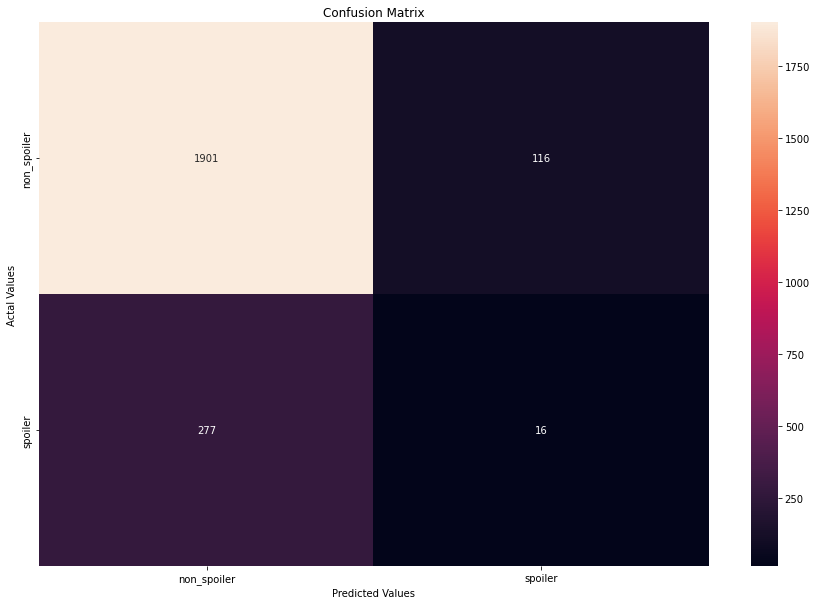

In [ ]:
classes = ['non_spoiler','spoiler']
cm = confusion_matrix(clf.predict(X_test), y_test)
cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

#Plotting the confusion matrix
plt.figure(figsize=(15,10))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

# Topic Modelling 

In [ ]:
lda_gensim = LdaModel(corpus_1, num_topics= 5, id2word=dictionary,
offset=2,
random_state=100,
update_every=1,
passes=10,
alpha='auto',
eta="auto",
per_word_topics=True)

In [ ]:
pyLDAvis.gensim.prepare(lda_gensim, corpus_1, dictionary, mds='tsne')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      150.222153  -72.269554       1        1  30.069429
0       51.163364 -159.968018       2        1  25.303438
4      -73.144554   21.523815       3        1  25.009201
2      -66.410133 -110.606438       4        1  13.021637
1       54.417324   12.443444       5        1   6.596295, topic_info=          Term         Freq        Total Category  logprob  loglift
109       read  5825.000000  5825.000000  Default  30.0000  30.0000
173     series  2841.000000  2841.000000  Default  29.0000  29.0000
61       story  6031.000000  6031.000000  Default  28.0000  28.0000
41        love  4283.000000  4283.000000  Default  27.0000  27.0000
10   character  5797.000000  5797.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
27         get   144.869539  3252.100511   Topic5  -5.5830  -0.3926
26       first   136.336969  2828.392581   Topic5  -5.6437  -0.3137
109       read   149.125905  5825.526858   Topic5  -5.5540  -0.9466
395      world   126.170910  1873.035039   Topic5  -5.7212   0.0210
61       story   119.570221  6031.552968   Topic5  -5.7749  -1.2022

[459 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1660      1  0.874719     ability
1660      2  0.060809     ability
1660      3  0.032743     ability
1660      4  0.028066     ability
3663      1  0.097478  adaptation
...     ...       ...         ...
1424      4  0.030383       young
1424      5  0.210992       young
4834      3  0.134228        zach
4834      4  0.850109        zach
5500      4  0.987593         zoe

[1026 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 5, 3, 2])

In [ ]:
pprint(lda_gensim.print_topics())

[(0,
  '0.021*"like" + 0.016*"really" + 0.010*"one" + 0.010*"thing" + 0.009*"read" '
  '+ 0.008*"get" + 0.008*"character" + 0.008*"think" + 0.008*"time" + '
  '0.008*"know"'),
 (1,
  '0.007*"one" + 0.007*"life" + 0.007*"year" + 0.006*"find" + 0.006*"harry" + '
  '0.005*"mother" + 0.005*"new" + 0.005*"father" + 0.005*"brother" + '
  '0.004*"family"'),
 (2,
  '0.022*"read" + 0.020*"story" + 0.019*"character" + 0.011*"one" + '
  '0.011*"like" + 0.010*"really" + 0.008*"plot" + 0.008*"much" + 0.008*"first" '
  '+ 0.008*"series"'),
 (3,
  '0.012*"story" + 0.010*"character" + 0.009*"one" + 0.007*"time" + '
  '0.006*"world" + 0.006*"life" + 0.005*"novel" + 0.005*"like" + 0.005*"also" '
  '+ 0.005*"read"'),
 (4,
  '0.018*"love" + 0.013*"series" + 0.013*"one" + 0.012*"read" + 0.011*"loved" '
  '+ 0.010*"like" + 0.010*"really" + 0.009*"character" + 0.008*"story" + '
  '0.008*"get"')]


In [ ]:
# perplexity
print('perplexity: ', lda_gensim.log_perplexity(corpus_1))

perplexity:  -7.606279145354245


In [ ]:
# coherence
coherence_model = CoherenceModel(model = lda_gensim, texts = texts, dictionary = dictionary, corpus = corpus_1, coherence = 'c_v')
coherence_lda = coherence_model.get_coherence()
print('coherence score: ', coherence_lda)

coherence score:  0.3030106654504089
